# Load modules

In [18]:
%load_ext autoreload
%autoreload 2
import pyro
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from pyrovelocity.utils import mRNA, debug, tau_inv, ode_mRNA
import torch
from torch import nn
import scvelo as scv
kwargs = dict(linewidth=1.5, density=.8, color='celltype', frameon=False, add_margin=.1, alpha=.1, min_mass=3.5, add_outline=True, outline_width=(.02, .02))
from scipy.stats import spearmanr, pearsonr
from pyrovelocity.api import train_model
import seaborn as sns
import pandas as pd
from pyrovelocity.plot import plot_posterior_time, plot_gene_ranking,\
      vector_field_uncertainty, plot_vector_field_uncertain,\
      plot_mean_vector_field, project_grid_points,rainbowplot,plot_arrow_examples
from pyrovelocity.utils import mae, mae_evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reproduce fully mature cell type problem

In [2]:
adata = scv.datasets.pbmc68k()
scv.pp.remove_duplicate_cells(adata)
adata.obsm["X_tsne"][:, 0] *= -1

  0%|          | 0.00/118M [00:00<?, ?B/s]

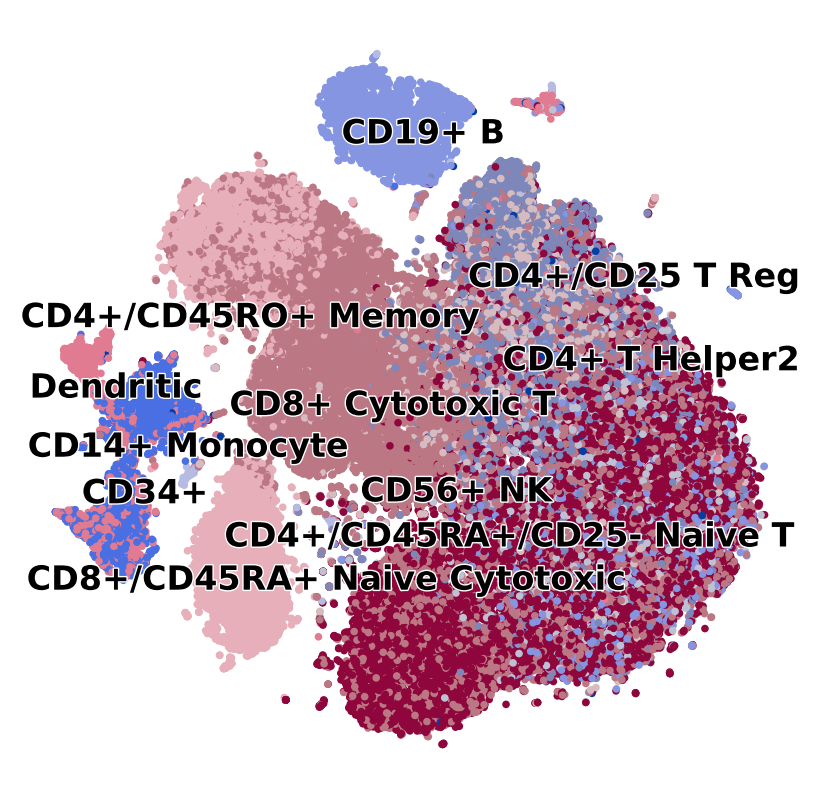

In [3]:
scv.pl.scatter(adata, c='celltype', s=30, legend_fontsize=12, legend_align_text=True, title='', figsize=(5, 5))

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata)

Filtered out 33500 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    finished (0:00:38) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata, n_jobs=-1)

recovering dynamics (using 256/256 cores)


  0%|          | 0/43 [00:00<?, ?gene/s]

    finished (0:00:46) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


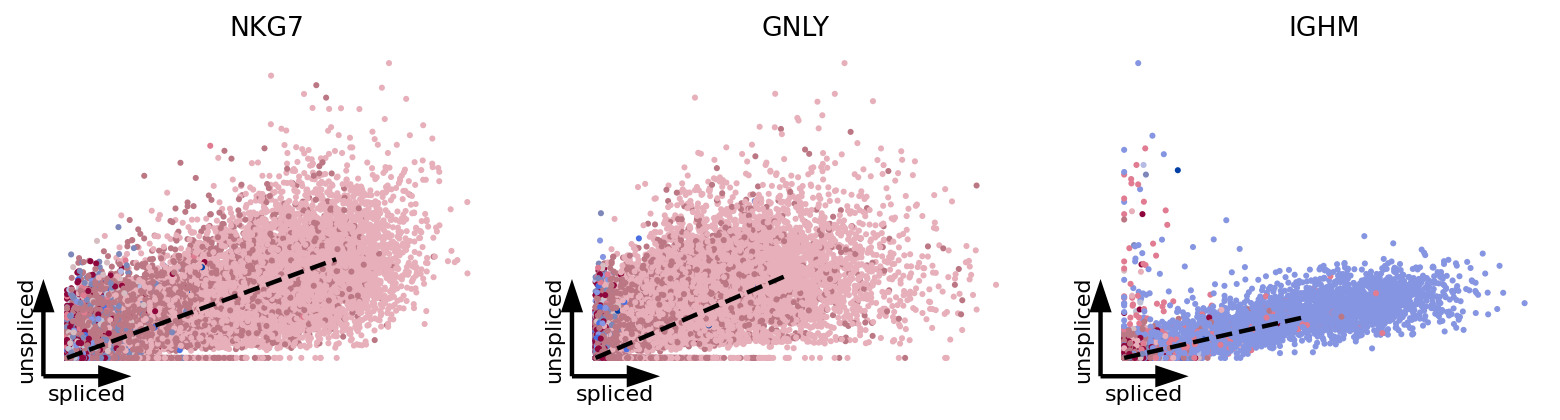

In [7]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:3], vkey='velocity', c='celltype', ncols=5, s=30, linewidth=2, frameon='artist', dpi=80)

In [8]:
adata_sub =  adata[:, top_genes[:3]].copy()

In [9]:
scv.tl.velocity_graph(adata_sub, n_jobs=-1)
scv.tl.velocity_embedding(adata_sub)

computing velocity graph (using 256/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:55) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


In [10]:
np.random.seed(99)
adata_sub.layers['velocity_with_noise'] = adata_sub.layers['velocity'] + np.random.normal(adata_sub.layers['velocity'], scale=adata_sub.layers['Ms'].std(0))
scv.tl.velocity_graph(adata_sub, gene_subset=top_genes[:3], vkey='velocity_with_noise', n_jobs=-1)
scv.tl.velocity_embedding(adata_sub, vkey='velocity_with_noise', autoscale=False)

computing velocity graph (using 256/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:45) --> added 
    'velocity_with_noise_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_with_noise_tsne', embedded velocity vectors (adata.obsm)


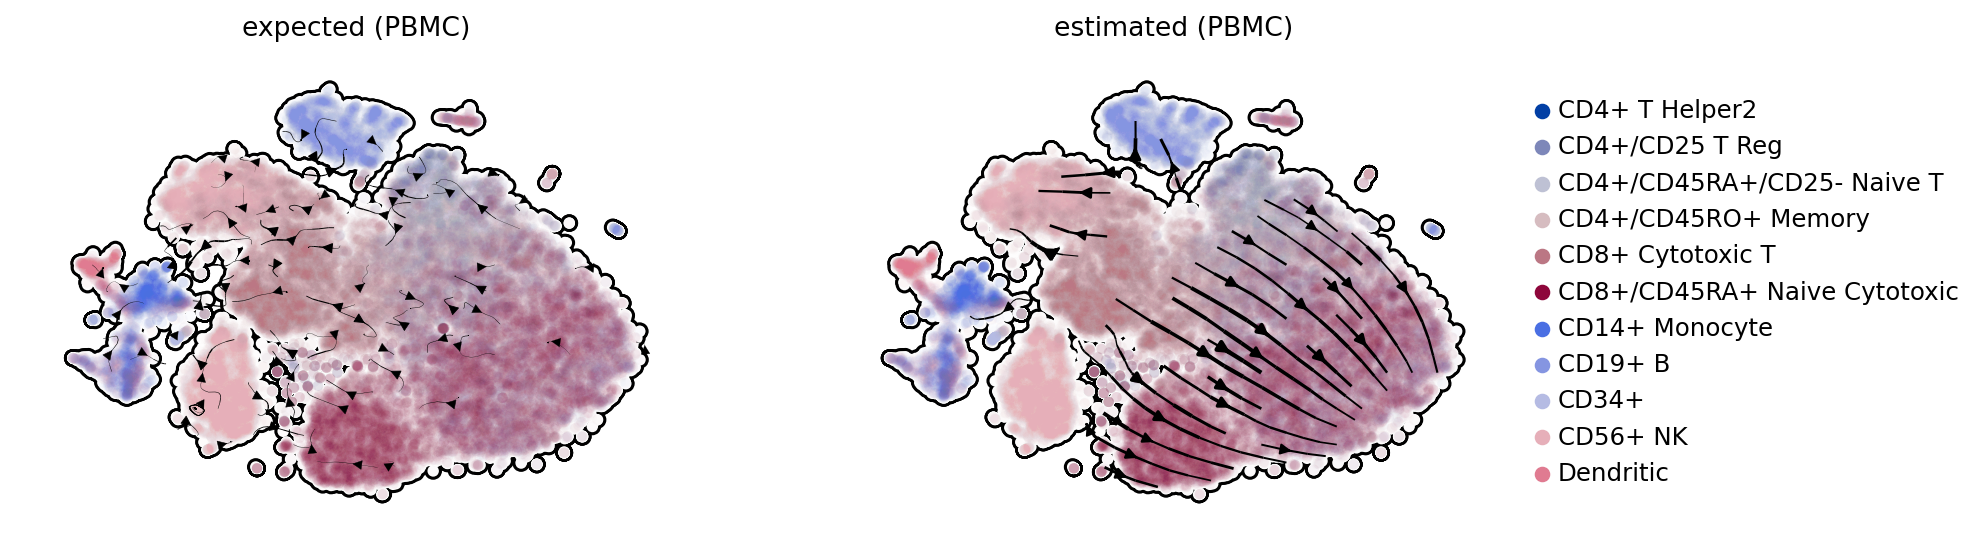

In [11]:
gs = scv.pl.gridspec(2)
kwargs = dict(color='celltype', density=.8, add_margin=.1, alpha=.02, min_mass=3.5, add_outline=True, frameon=False)
scv.pl.velocity_embedding_stream(adata_sub, vkey='velocity_with_noise', legend_loc='none', title='expected (PBMC)', ax=gs[0], **kwargs)
scv.pl.velocity_embedding_stream(adata_sub, linewidth=1.5, legend_loc='right', title='estimated (PBMC)', ax=gs[1], **kwargs)

# PBMC Pyro-velocity estimation of uncertainty

In [12]:
adata_all = scv.datasets.pbmc68k()
adata_all.obs['u_lib_size'] = adata_all.layers['unspliced'].toarray().sum(-1)
adata_all.obs['s_lib_size'] = adata_all.layers['spliced'].toarray().sum(-1)
adata_sub.layers['raw_spliced'] = adata_all[:, adata_sub.var_names].layers['spliced']
adata_sub.layers['raw_unspliced'] = adata_all[:, adata_sub.var_names].layers['unspliced']
adata_sub.obs['u_lib_size_raw'] = np.array(adata_sub.layers['raw_unspliced'].sum(axis=-1), dtype=np.float32).flatten()
adata_sub.obs['s_lib_size_raw'] = np.array(adata_sub.layers['raw_spliced'].sum(axis=-1), dtype=np.float32).flatten()

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["raw_unspliced"]                                                             
INFO     Using data from adata.layers["raw_spliced"]                                                               
INFO     Successfully registered anndata object containing 65877 cells, 3 vars, 1 batches, 1 labels, and 0         
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 65877 │
│             Vars             │   3   │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto_t0_constraint
step    0 loss = 1.74021e+06 patience = 45
step  100 loss = 1.28479e+06 patience = 45
step  200 loss = 1.01332e+06 patience = 45
step  300 loss = 848424 patience = 45
step  400 loss = 760072 patience = 45
step  500 loss = 702354 patience = 45
step  600 loss = 657546 patience = 43
step  700 loss = 638181 patience = 45
step  800 loss = 622194 patience = 45
step  900 loss = 593874 patience = 45
step 1000 loss = 587316 patience = 45
step 1100 loss = 568997 patience = 45
step 1200 loss = 650035 patience = 45
step 1300 loss = 568668 patience = 44
step 1400 loss = 592928 patience = 43
step 1500 loss = 1.6475e+06 patience = 45
step 1600 loss = 640139 patience = 44
step 1700 loss = 634879 patience = 45
step 1800 loss = 637467 patience = 44
step 1900 loss = 932600 patience = 45
step 2000 loss = 713719 patience = 45
step 2100 loss = 1.12977e+06 patience = 44
step 2200 loss = 769743 patience = 45
step 2300 loss = 894952 patience = 43
step 2400 loss = 1.14781e+06

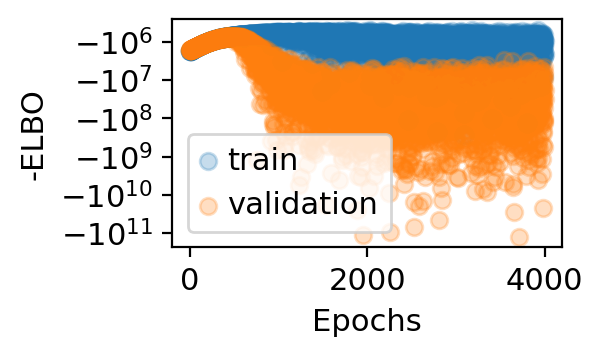

In [15]:
adata_model_pos = train_model(adata_sub, max_epochs=4000, svi_train=False, log_every=100,
                              patient_init=45, batch_size=-1, use_gpu=1, 
                              include_prior=True, offset=False, library_size=True,
                              cell_state='celltype',
                              patient_improve=1e-4, guide_type='auto_t0_constraint', train_size=0.67)

                      MAE
label                    
Poisson train    6.980672
Poisson valid  200.731020


,MAE,label
0,3.726239,Poisson train
1,2.510894,Poisson train
2,0.767772,Poisson train
3,1.719902,Poisson train
4,3.795361,Poisson train
5,2.484646,Poisson train
6,2.518356,Poisson train
7,2.931354,Poisson train
8,1.600094,Poisson train
9,1.509958,Poisson train


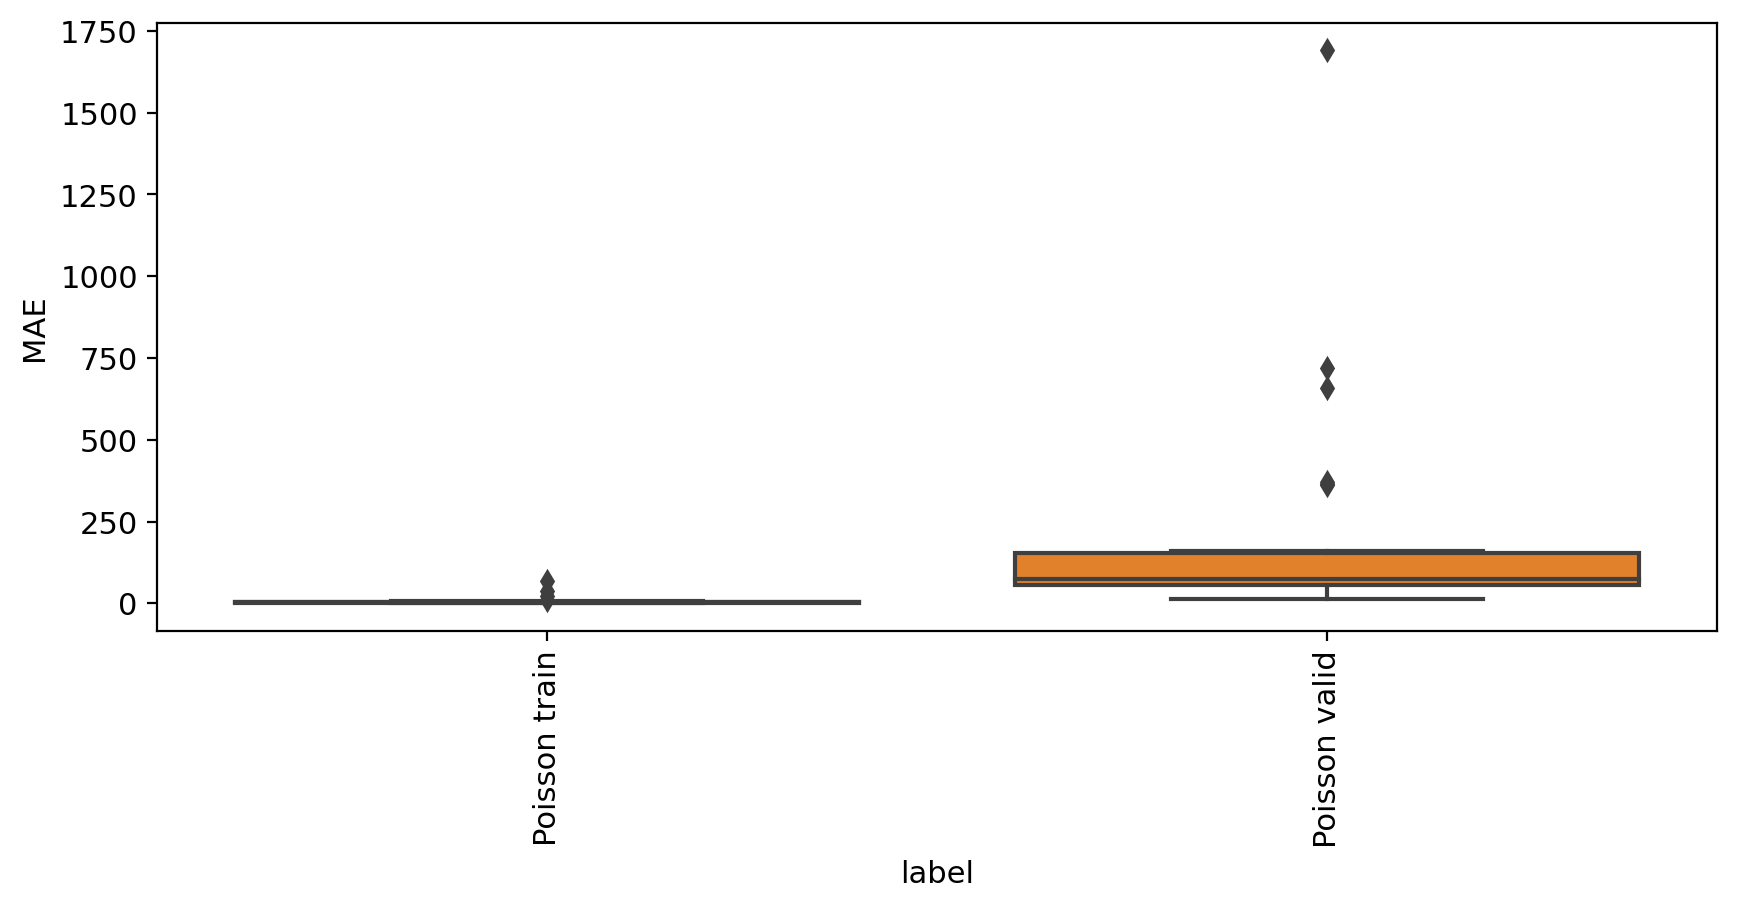

In [19]:
mae_evaluate(adata_model_pos, adata_sub)

INFO     No batch_key inputted, assuming all cells are same batch                                                  


INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["raw_unspliced"]                                                             


INFO:scvi.data._anndata:Using data from adata.layers["raw_unspliced"]


INFO     Using data from adata.layers["raw_spliced"]                                                               


INFO:scvi.data._anndata:Using data from adata.layers["raw_spliced"]


INFO     Successfully registered anndata object containing 65877 cells, 3 vars, 1 batches, 1 labels, and 0         
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 65877 cells, 3 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 65877 │
│             Vars             │   3   │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto_t0_constraint
TraceEnum
step    0 loss = 4.40379 patience = 45
step  100 loss = 3.25319 patience = 45
step  200 loss = 2.56925 patience = 45
step  300 loss = 2.15012 patience = 45
step  400 loss = 1.92119 patience = 45
step  500 loss = 1.76497 patience = 44
step  600 loss = 1.64497 patience = 44
step  700 loss = 1.55589 patience = 45
step  800 loss = 1.4728 patience = 45
step  900 loss = 1.40488 patience = 45
step 1000 loss = 1.34187 patience = 45
step 1100 loss = 1.29919 patience = 44
step 1200 loss = 1.25588 patience = 45
step 1300 loss = 1.19023 patience = 44
step 1400 loss = 1.21275 patience = 43
step 1500 loss = 1.53524 patience = 45
step 1600 loss = 1.14568 patience = 45
step 1700 loss = 1.11495 patience = 45
step 1800 loss = 1.07038 patience = 44
step 1900 loss = 1.18413 patience = 45
step 2000 loss = 1.06284 patience = 45
step 2100 loss = 1.15266 patience = 44
step 2200 loss = 1.11234 patience = 45
step 2300 loss = 1.15595 patience = 43
step 2400 loss = 1.

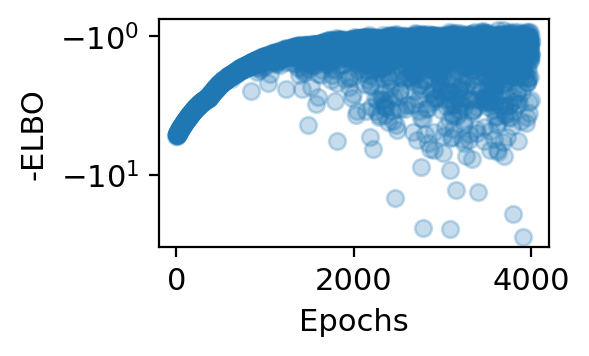

In [20]:
adata_model_pos = train_model(adata_sub, max_epochs=4000, svi_train=False, log_every=100,
                              patient_init=45, batch_size=-1, use_gpu=1, cell_state='celltype',
                              offset=False, library_size=True,
                              patient_improve=1e-4, guide_type='auto_t0_constraint', train_size=1.0,
                              include_prior=True)

                        MAE
label                      
Poisson all cells  1.002032


,MAE,label
0,0.656059,Poisson all cells
1,0.640846,Poisson all cells
2,0.351339,Poisson all cells
3,1.448229,Poisson all cells
4,0.693919,Poisson all cells
5,1.402847,Poisson all cells
6,0.561997,Poisson all cells
7,0.538951,Poisson all cells
8,0.525482,Poisson all cells
9,0.540181,Poisson all cells


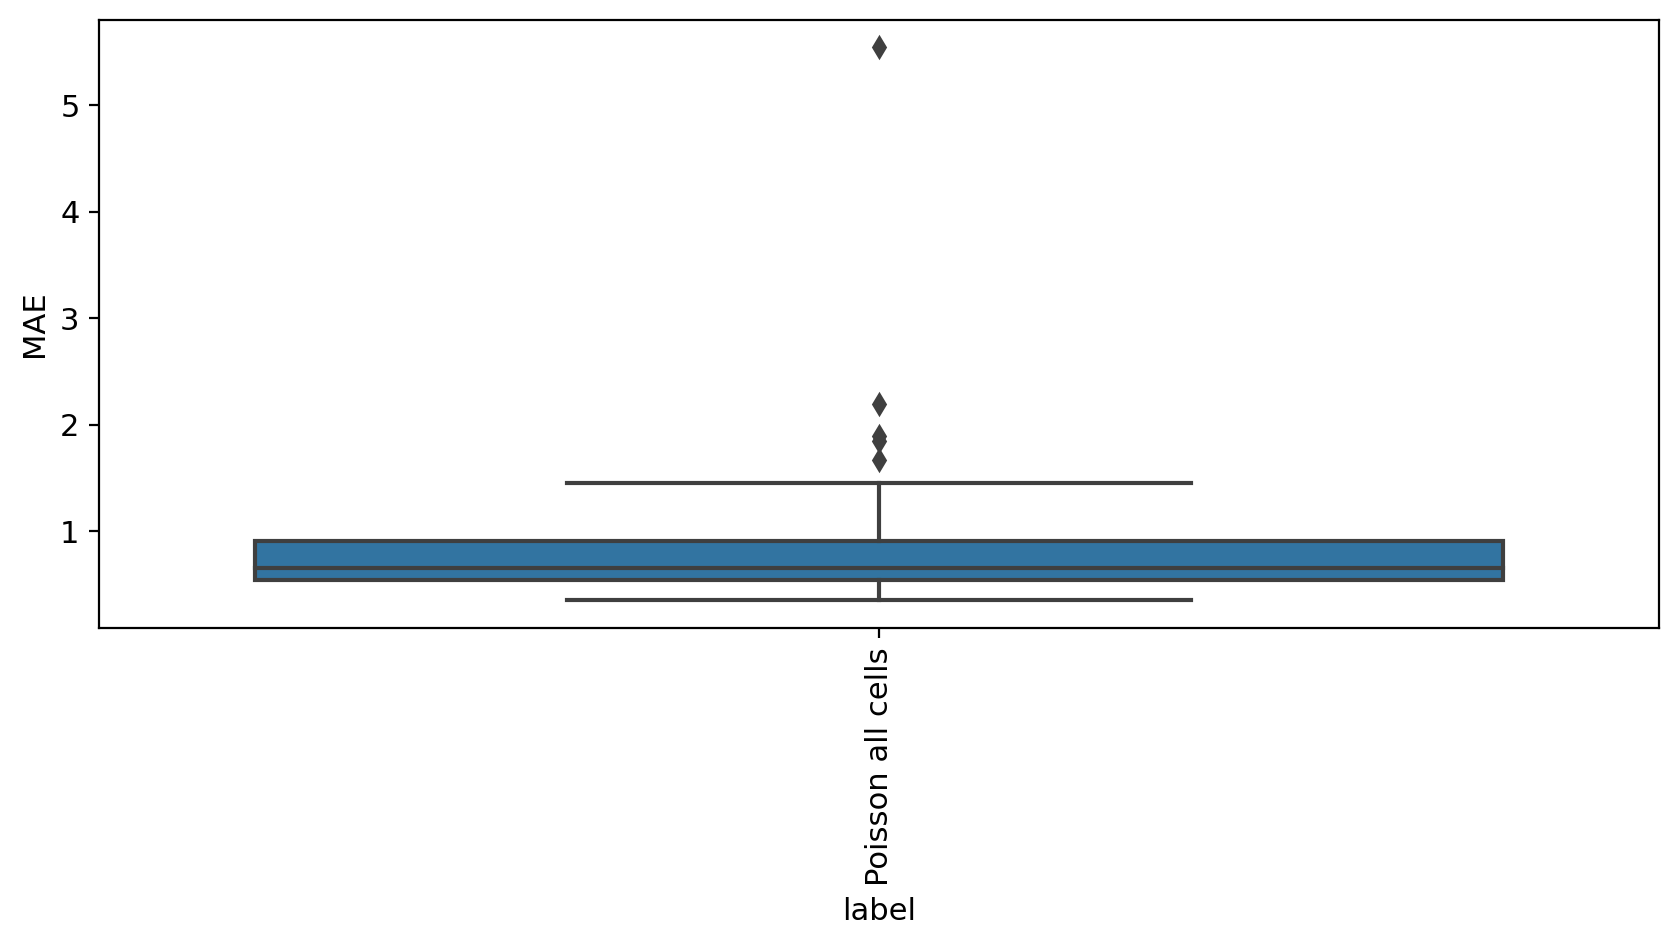

In [22]:
mae_evaluate(adata_model_pos[1], adata_sub)

In [24]:
v_map_all, embeds_radian, fdri = vector_field_uncertainty(adata_sub, adata_model_pos[1], n_jobs=20)

computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:56) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:17) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:00) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:17) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:53) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:17) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:58) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:54) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:59) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:52) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:00) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:53) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:54) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:00) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:55) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:54) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:59) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:54) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:59) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:53) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:59) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:53) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:05) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:53) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:17) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:54) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:00) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:54) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:59) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:16) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)


computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 20/256 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:17) --> added
    'velocity_pyro_tsne', embedded velocity vectors (adata.obsm)


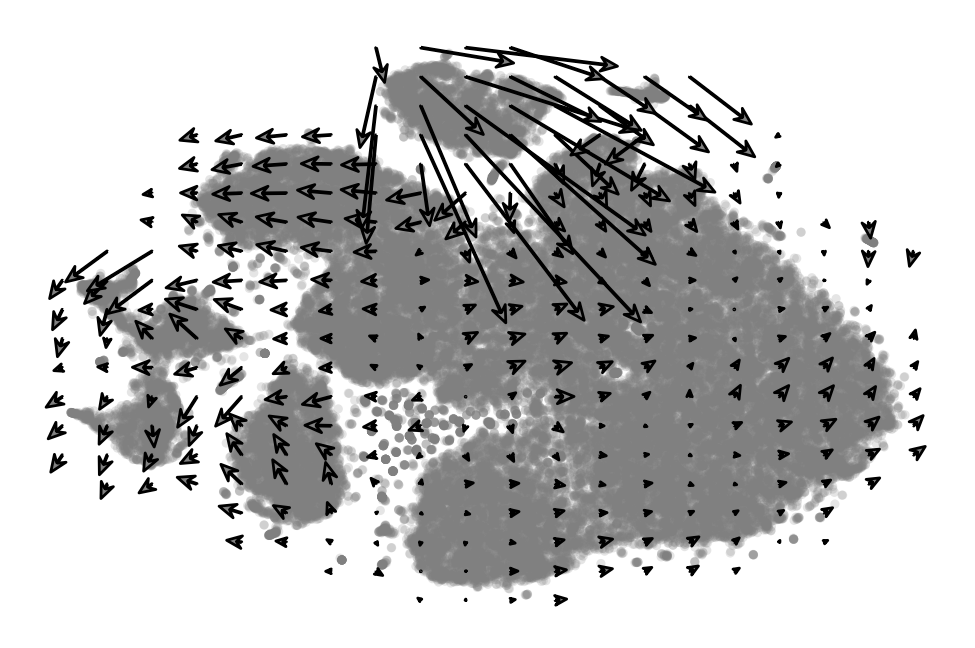

In [26]:
fig, ax = plt.subplots()
embed_mean = plot_mean_vector_field(adata_model_pos[1], adata_sub, ax=ax, basis='tsne', n_jobs=20)

In [27]:
(fdri < 0.01).sum(), (fdri < 0.01).sum()/fdri.shape[0], fdri.shape, adata_sub.shape

(1743, 0.02645839974497928, (65877,), (65877, 3))

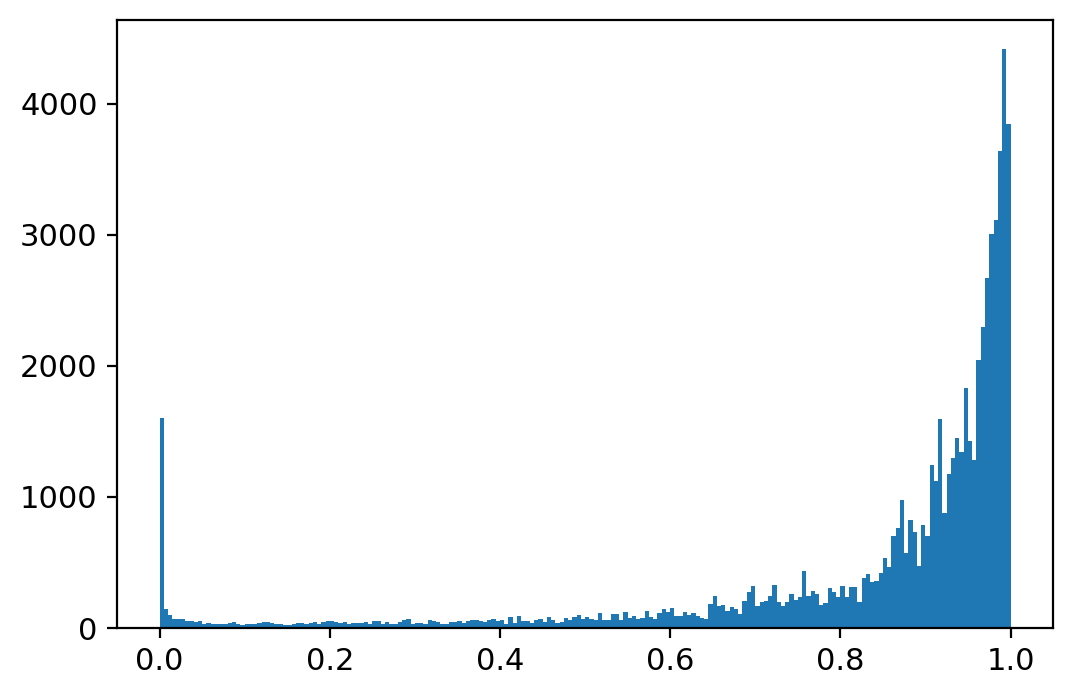

In [28]:
_ = plt.hist(fdri, bins=200)

V_grid.........
V_grid.........
60 50 40


Text(-0.06, 0.58, 'PBMC')

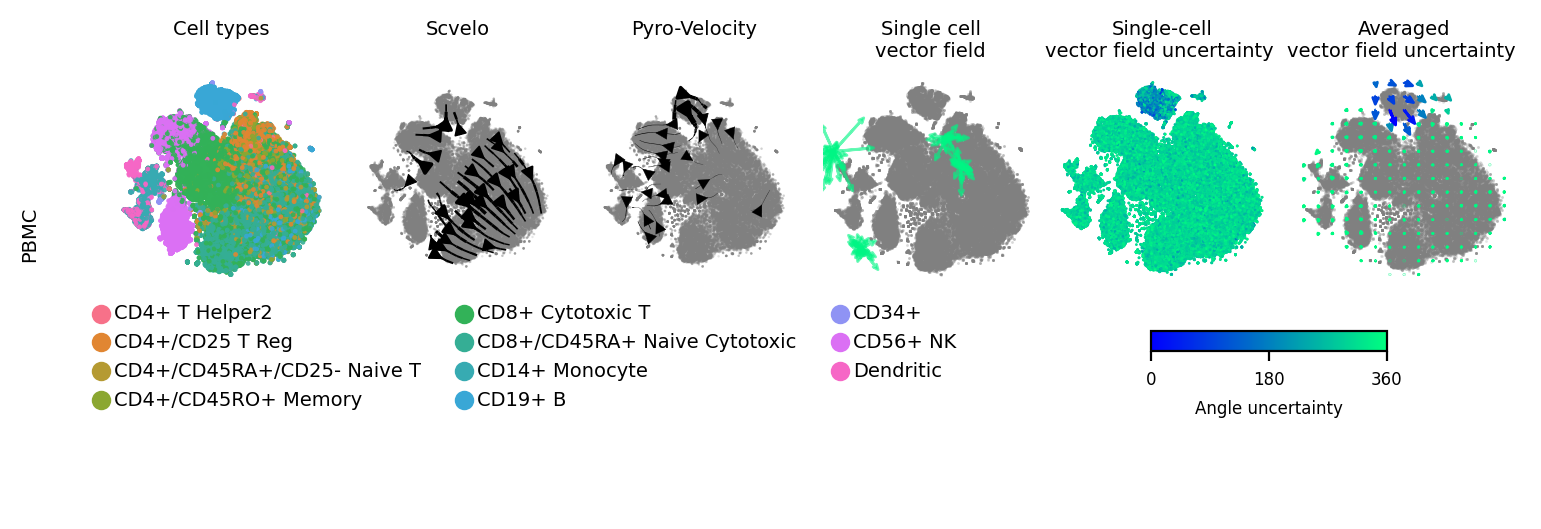

In [34]:
fig = plt.figure(figsize=(7.07, 2.2))
subfig_A = fig.subfigures(2, 1, wspace=0.0, hspace=0, height_ratios=[1.6, 0.2])

dot_size = 3
font_size = 7

ress = pd.DataFrame({"cell_type": adata_sub.obs['celltype'].values,
                     "X1": adata_sub.obsm['X_tsne'][:,0],
                     "X2": adata_sub.obsm['X_tsne'][:,1]})
#fig, ax = plt.subplots(1, 5)

subfig_A0 = subfig_A[0].subfigures(1, 2, wspace=0.0, hspace=0, width_ratios=[4, 2])

ax = subfig_A0[0].subplots(1, 4)

sns.scatterplot(x='X1', y='X2', data=ress, alpha=0.9, s=dot_size,
                linewidth=0, edgecolor="none", hue='cell_type', 
                ax=ax[0], legend='brief')
ax[0].axis('off')
ax[0].set_title("Cell types\n", fontsize=font_size)
ax[0].legend(bbox_to_anchor=[4.0, -0.01], ncol=3, prop={'size': font_size}, fontsize=font_size, frameon=False)

kwargs = dict(color='gray', density=.8, add_margin=.1, s=dot_size,
              show=False, alpha=.2, min_mass=3.5, frameon=False)
scv.pl.velocity_embedding_stream(adata_sub, basis='tsne', fontsize=font_size, ax=ax[1], title='', **kwargs)
ax[1].set_title("Scvelo\n", fontsize=7)

scv.pl.velocity_embedding_stream(adata_sub, fontsize=font_size, basis='tsne', 
                                 title='', ax=ax[2], vkey='velocity_pyro', **kwargs)
ax[2].set_title("Pyro-Velocity\n", fontsize=7)

# plot_arrow_examples(adata_train, np.transpose(v_map_all, (1, 2, 0)), embeds_radian, ax=ax[3],
#                     n_sample=30, fig=fig, basis='umap', scale=0.004, alpha=0.18)
plot_arrow_examples(adata_sub, np.transpose(v_map_all, (1, 2, 0)), embeds_radian, ax=ax[3],
                    n_sample=30, fig=fig, basis='tsne', scale=0.001, alpha=0.3, index=100,
                    scale2=None, num_certain=0, num_total=4)
ax[3].set_title("Single cell\nvector field", fontsize=7)

plot_vector_field_uncertain(adata_sub, embed_mean, embeds_radian, fig=subfig_A0[1], cbar=True,
                            basis='tsne',
                            scale=0.018, arrow_size=5)
subfig_A0[0].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.45)
subfig_A0[1].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.45)

subfig_A[0].text(-0.06, 0.58, "PBMC", size=7, rotation="vertical", va="center")

In [35]:
fig.savefig("fully_mature_pbmc_figure1.tif", facecolor=fig.get_facecolor(), bbox_inches='tight', edgecolor='none', dpi=300)

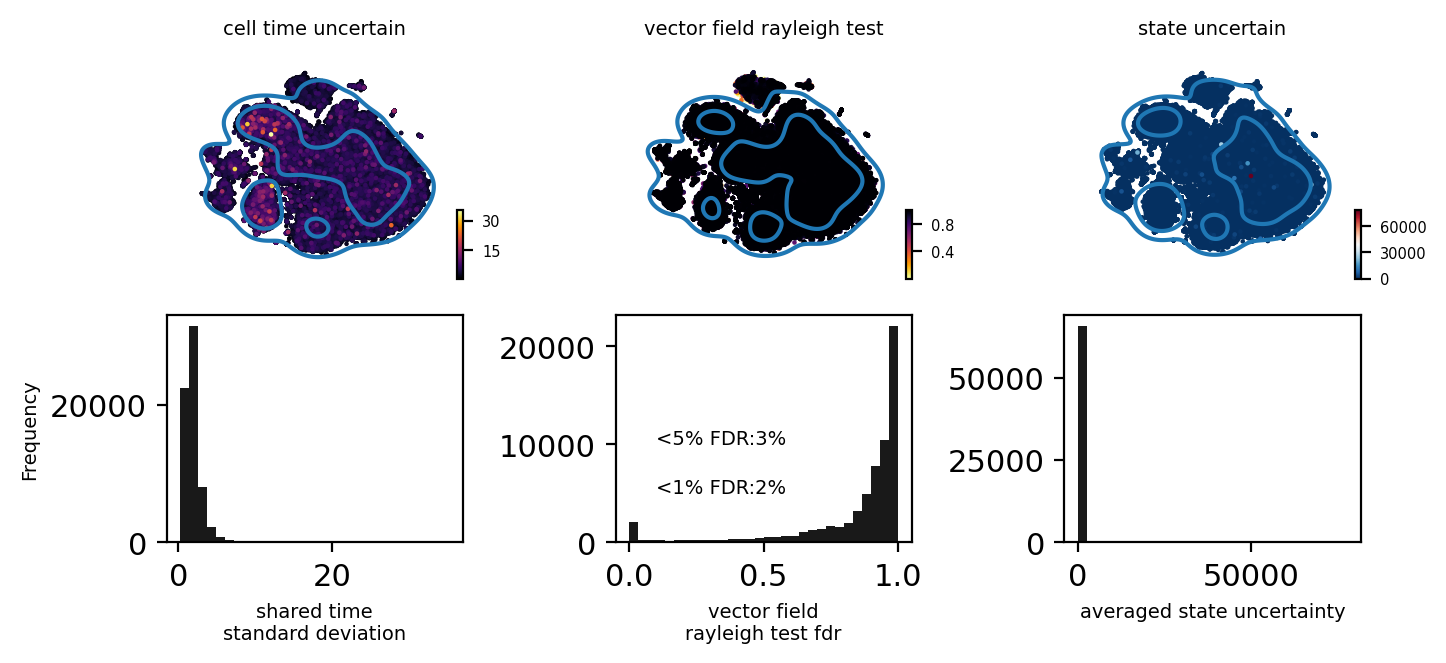

In [42]:
from pyrovelocity.plot import plot_state_uncertainty
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(7.07, 3.5)
pos = adata_model_pos[1]
bin = 30
adata_sub.obs['cell_time_uncertain'] = adata_model_pos[1]['cell_time'].std(0).flatten()
scv.pl.scatter(adata_sub, c='cell_time_uncertain', ax=ax[0][0], 
               basis='tsne', show=False, cmap='inferno', fontsize=7)
select = adata_sub.obs['cell_time_uncertain'] > np.quantile(adata_sub.obs['cell_time_uncertain'], 0.9)
sns.kdeplot(adata_sub.obsm['X_tsne'][:, 0][select],
            adata_sub.obsm['X_tsne'][:, 1][select], ax=ax[0][0], levels=3, fill=False)

_ = ax[1][0].hist(adata_sub.obs.cell_time_uncertain, bins=bin, color='black', alpha=0.9)
ax[1][0].set_xlabel("shared time\nstandard deviation", fontsize=7)

adata_sub.obs['vector_field_rayleigh_test'] = fdri
scv.pl.scatter(adata_sub, c='vector_field_rayleigh_test',
               basis='tsne', ax=ax[0][1], show=False, cmap='inferno_r', fontsize=7)
select = adata_sub.obs['vector_field_rayleigh_test'] > np.quantile(adata_sub.obs['vector_field_rayleigh_test'], 0.9)
sns.kdeplot(adata_sub.obsm['X_tsne'][:, 0][select],
            adata_sub.obsm['X_tsne'][:, 1][select], ax=ax[0][1], levels=3, fill=False)
_ = ax[1][1].hist(adata_sub.obs.vector_field_rayleigh_test, bins=bin, color='black', alpha=0.9)
ax[1][1].set_xlabel("vector field\nrayleigh test fdr", fontsize=7)
ax[1][1].text(0.1, 5e3, "<1%% FDR:%s%%" % int((fdri < 0.01).sum()/fdri.shape[0]*100), fontsize=7)
ax[1][1].text(0.1, 1e4, "<5%% FDR:%s%%" % int((fdri < 0.05).sum()/fdri.shape[0]*100), fontsize=7)

fig.subplots_adjust(hspace=0.3, wspace=0.7, left=0.01, right=0.8, top=0.92, bottom=0.17)
plot_state_uncertainty(pos, adata_sub, 
                       basis='tsne', kde=True, data='raw', top_percentile=0.9, ax=ax[0][2])

_ = ax[1][2].hist(adata_sub.obs['state_uncertain'], bins=bin, color='black', alpha=0.9)
ax[1][2].set_xlabel("averaged state uncertainty", fontsize=7)
ax[1][0].set_ylabel("Frequency", fontsize=7)
fig.tight_layout()

In [43]:
fig.savefig("fully_mature_pbmc_figure2.tif", facecolor=fig.get_facecolor(), bbox_inches='tight', edgecolor='none', dpi=300)